In [1]:
import functools
import os
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt


@functools.wraps(smf.ols)
def lm(*args, **kwargs):
    return smf.ols(*args, **kwargs).fit()

In [3]:
np.random.seed(0)

In [4]:
os.chdir("../../data")

In [5]:
recommendee = "mpfei"

In [6]:
raw_df = pd.read_csv("UserAnimeList.csv")

In [7]:
filtered_df = raw_df[["username", "anime_id", "my_score"]].loc[
    lambda x: x["my_score"] != 0
]

In [8]:
# add additional user anime-lists
extraUsers = pickle.load(open("user_profiles/ExtraUserAnimeLists.pkl", "rb"))
filtered_df = filtered_df.loc[lambda x: ~x["username"].isin(extraUsers.username)]
filtered_df = pd.concat([filtered_df, extraUsers], ignore_index=True)

In [9]:
average_rating = filtered_df["my_score"].mean()
user_bias = (
    pd.DataFrame(filtered_df.groupby("username")["my_score"].mean()).rename(
        {"my_score": "user_bias"}, axis=1
    )
    - average_rating
)
anime_bias = (
    pd.DataFrame(filtered_df.groupby("anime_id")["my_score"].mean()).rename(
        {"my_score": "anime_bias"}, axis=1
    )
    - average_rating
)

In [10]:
filtered_df = filtered_df.merge(anime_bias, on=["anime_id"]).merge(
    user_bias, on=["username"]
)
filtered_df["normalized_score"] = (
    filtered_df["my_score"]
    - filtered_df["anime_bias"]
    - filtered_df["user_bias"]
    - average_rating
)
filtered_df["orig_normalized_score"] = filtered_df["normalized_score"]
filtered_df = filtered_df.set_index("username")
filtered_df = filtered_df.dropna()

In [11]:
def prepare_prediction(recommendee, neighborhood):
    pred_df = pd.DataFrame()
    pred_df["delta"] = neighborhood.groupby("anime_id").apply(
        lambda x: np.dot(x["normalized_score"], x["corr"]) / x["corr"].abs().sum()
    )
    pred_df["blp"] = anime_bias + user_bias.loc[recommendee].squeeze() + average_rating
    pred_df = pred_df.dropna()
    return pred_df

In [12]:
def get_squared_error(df, pred_df, recommendee):
    recommendee_df = pred_df.loc[
        pred_df.index.intersection(df.loc[recommendee].anime_id)
    ]
    recommendee_df = recommendee_df.merge(
        df.loc[recommendee].set_index("anime_id")["my_score"], on="anime_id"
    )
    errors = recommendee_df["my_score"] - recommendee_df["score"]
    return np.dot(errors, errors)

In [13]:
filtered_df.head()

,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
karthiga,21,9,0.960563,-0.059899,0.605474,0.605474
karthiga,59,7,0.040202,-0.059899,-0.474165,-0.474165
karthiga,74,7,0.316282,-0.059899,-0.750244,-0.750244
karthiga,120,7,0.309858,-0.059899,-0.743820,-0.743820
karthiga,178,7,-0.227339,-0.059899,-0.206623,-0.206623


In [14]:
all_corrs = pickle.load(open("item_correlations/correlations.pkl", "rb"))
all_corrs["similarity"] = all_corrs["corr"].abs()
all_corrs = all_corrs.dropna()
all_corrs = all_corrs.loc[
    lambda x: x.index.get_level_values("anime_id_x")
    != x.index.get_level_values("anime_id_y")
]
all_corrs = all_corrs.sort_values(by="similarity")
all_corrs_nonneg = all_corrs.sort_values(by="corr")

In [15]:
def compute_accuracy_metrics(
    is_df, oos_df, corrs, recommendee, neighborhood_sizes, nonneg_corrs
):
    anime_var = (
        pd.DataFrame(is_df.groupby("anime_id")["normalized_score"].var())
        .rename({"normalized_score": "anime_var"}, axis=1)
        .dropna()
    )
    user_var = (
        pd.DataFrame(is_df.groupby("username")["normalized_score"].var())
        .rename({"normalized_score": "user_var"}, axis=1)
        .dropna()
    )

    metrics = pd.DataFrame()
    for neighborhood_size in reversed(sorted(neighborhood_sizes)):
        # extract model features
        corrs = corrs.groupby("anime_id_x").tail(neighborhood_size)

        score = is_df.loc[recommendee].merge(
                corrs.reset_index("anime_id_x"),
                left_on="anime_id",
                right_on="anime_id_y",
            )
        score["user_var"] = user_var.loc[recommendee].squeeze()
        score = score.merge(anime_var, on="anime_id")
        score = score.drop("anime_id", axis=1).rename(
                {"anime_id_x": "anime_id"}, axis=1
            )
        pred_df = prepare_prediction(recommendee, score)

        # train linear model
        recomendee_seen_shows = is_df.loc[recommendee].merge(pred_df, on=["anime_id"])
        recomendee_seen_shows["target"] = (
            recomendee_seen_shows["my_score"] - recomendee_seen_shows["blp"]
        )
        model = lm("target ~ delta + 0", recomendee_seen_shows)

        # inference
        pred_df["score"] = model.predict(pred_df) + pred_df["blp"]
        is_pred_df = pred_df.loc[
            lambda x: x.index.isin(is_df.loc[recommendee].anime_id)
        ]
        oos_pred_df = pred_df.loc[lambda x: x.index.isin(oos_df.anime_id)]

        # compute coverage
        is_coverage = len(is_pred_df) / len(is_df.loc[recommendee])
        oos_coverage = len(oos_pred_df) / len(oos_df)

        # compute rmse
        missing_is = is_df.loc[recommendee].loc[
            lambda x: ~x.anime_id.isin(is_pred_df.index)
            & ~x.anime_id.isin(oos_df.anime_id)
        ]
        missing_oos = oos_df.loc[lambda x: ~x.anime_id.isin(oos_pred_df.index)]
        is_se = get_squared_error(is_df, is_pred_df, recommendee)
        oos_se = get_squared_error(oos_df, oos_pred_df, recommendee)
        missing_is_se = np.dot(
            missing_is["orig_normalized_score"], missing_is["orig_normalized_score"]
        )
        missing_oos_se = np.dot(
            missing_oos["orig_normalized_score"], missing_oos["orig_normalized_score"]
        )
        is_rmse = np.sqrt((is_se + missing_is_se) / len(is_df.loc[recommendee]))
        oos_rmse = np.sqrt((oos_se + missing_oos_se) / len(oos_df))
        metrics = metrics.append(
            {
                "neighborhood_size": neighborhood_size,
                "nonneg_corrs": nonneg_corrs,
                "is_rmse": is_rmse,
                "is_coverage": is_coverage,
                "oos_rmse": oos_rmse,
                "oos_coverage": oos_coverage,
            },
            ignore_index=True,
        )

    return metrics

In [16]:
%%time
from tqdm import tqdm

K = 10
base = np.sqrt(2)

errors_by_neighborhood_size = []
max_size = len(filtered_df.anime_id.unique())
neighborhood_sizes = [
    int(base ** i) for i in range(int(np.log(max_size) / np.log(base)) + 1)
] + [max_size]
neighborhood_sizes = sorted(list(set(neighborhood_sizes)))
splits = np.array_split(filtered_df.loc[recommendee].sample(frac=1), K)
for split in splits:
    display(split.head())

for split in tqdm(splits):
    oos_df = split
    is_df = filtered_df.loc[
        lambda x: ~(
            (x.index.get_level_values("username") == recommendee)
            & x.anime_id.isin(oos_df.anime_id)
        )
    ]
    # we take copies as a safety precaution
    errors_by_neighborhood_size.append(
        compute_accuracy_metrics(
            is_df.copy(),
            oos_df.copy(),
            all_corrs.copy(),
            recommendee,
            neighborhood_sizes,
            False,
        )
    )
    errors_by_neighborhood_size.append(
        compute_accuracy_metrics(
            is_df.copy(),
            oos_df.copy(),
            all_corrs_nonneg.copy(),
            recommendee,
            neighborhood_sizes,
            True,
        )
    )    

,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,6114,7,0.962501,0.533536,-1.989899,-1.989899
mpfei,82,8,0.281788,0.533536,-0.309185,-0.309185
mpfei,14813,9,0.507706,0.533536,0.464897,0.464897
mpfei,7311,9,1.350428,0.533536,-0.377825,-0.377825
mpfei,30276,9,1.149011,0.533536,-0.176408,-0.176408


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,32182,9,0.864817,0.533536,0.107785,0.107785
mpfei,268,8,0.494845,0.533536,-0.522242,-0.522242
mpfei,4382,9,-0.352282,0.533536,1.324884,1.324884
mpfei,24781,5,0.024080,0.533536,-3.051478,-3.051478
mpfei,18679,9,0.598908,0.533536,0.373695,0.373695


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,29803,5,0.417982,0.533536,-3.445379,-3.445379
mpfei,37999,9,1.506139,0.533536,-0.533536,-0.533536
mpfei,25519,8,-0.129936,0.533536,0.102539,0.102539
mpfei,13125,8,0.870968,0.533536,-0.898365,-0.898365
mpfei,245,8,1.187125,0.533536,-1.214522,-1.214522


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,21405,9,0.311698,0.533536,0.660905,0.660905
mpfei,12467,9,-0.268197,0.533536,1.240800,1.240800
mpfei,14397,7,1.051411,0.533536,-2.078808,-2.078808
mpfei,38659,8,0.506139,0.533536,-0.533536,-0.533536
mpfei,10087,7,1.009724,0.533536,-2.037121,-2.037121


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,30,8,0.724363,0.533536,-0.751761,-0.751761
mpfei,34152,8,-0.292988,0.533536,0.265590,0.265590
mpfei,849,9,0.589172,0.533536,0.383431,0.383431
mpfei,31240,7,0.816733,0.533536,-1.844131,-1.844131
mpfei,5040,8,0.874075,0.533536,-0.901473,-0.901473


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,31646,9,0.753426,0.533536,0.219177,0.219177
mpfei,1689,7,0.556230,0.533536,-1.583627,-1.583627
mpfei,1292,7,-0.291580,0.533536,-0.735817,-0.735817
mpfei,9756,9,0.981338,0.533536,-0.008736,-0.008736
mpfei,30831,9,0.499314,0.533536,0.473289,0.473289


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,7785,8,0.958918,0.533536,-0.986315,-0.986315
mpfei,721,8,0.625253,0.533536,-0.652650,-0.652650
mpfei,2001,7,1.194917,0.533536,-2.222315,-2.222315
mpfei,227,8,0.368341,0.533536,-0.395739,-0.395739
mpfei,2251,8,1.007394,0.533536,-1.034791,-1.034791


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,339,8,0.347777,0.533536,-0.375174,-0.375174
mpfei,1575,8,1.240077,0.533536,-1.267474,-1.267474
mpfei,22199,7,0.026090,0.533536,-1.053487,-1.053487
mpfei,32937,9,0.719981,0.533536,0.252622,0.252622
mpfei,2904,8,1.415048,0.533536,-1.442446,-1.442446


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,16664,10,0.760659,0.533536,1.211944,1.211944
mpfei,35180,9,1.478083,0.533536,-0.505481,-0.505481
mpfei,34933,6,-0.132314,0.533536,-1.895083,-1.895083
mpfei,10800,8,0.813220,0.533536,-0.840617,-0.840617
mpfei,31764,7,0.235000,0.533536,-1.262397,-1.262397


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
mpfei,11981,9,0.942518,0.533536,0.030084,0.030084
mpfei,486,8,0.890540,0.533536,-0.917937,-0.917937
mpfei,38826,8,0.506139,0.533536,-0.533536,-0.533536
mpfei,39195,9,1.006139,0.533536,-0.033536,-0.033536
mpfei,32979,9,0.100344,0.533536,0.872259,0.872259


100%|██████████| 10/10 [2:00:23<00:00, 722.33s/it]

CPU times: user 1h 8s, sys: 32min 10s, total: 1h 32min 18s
Wall time: 2h 27s


In [17]:
allerrors = pd.concat(errors_by_neighborhood_size, ignore_index=True)

In [18]:
allerrors

,is_coverage,is_rmse,neighborhood_size,nonneg_corrs,oos_coverage,oos_rmse
0,0.923077,1.156202,14091.0,0.0,0.875000,0.793472
1,0.923077,1.157248,8192.0,0.0,0.875000,0.787868
2,0.923077,1.156684,4096.0,0.0,0.875000,0.769045
3,0.923077,1.176284,2048.0,0.0,0.875000,0.742453
4,0.923077,1.165428,1024.0,0.0,0.875000,0.744255
...,...,...,...,...,...,...
295,0.787879,1.215451,16.0,1.0,0.428571,0.470106
296,0.757576,1.265033,8.0,1.0,0.428571,0.485547
297,0.606061,1.232049,4.0,1.0,0.142857,0.620675
298,0.484848,1.268223,2.0,1.0,0.000000,0.620633


In [19]:
wide_data = pd.melt(allerrors, ["neighborhood_size", "nonneg_corrs"])

In [20]:
wide_data.loc[lambda x: x.nonneg_corrs == True, "variable"] = (
    "nonneg_" + wide_data.loc[lambda x: x.nonneg_corrs == True, "variable"]
)

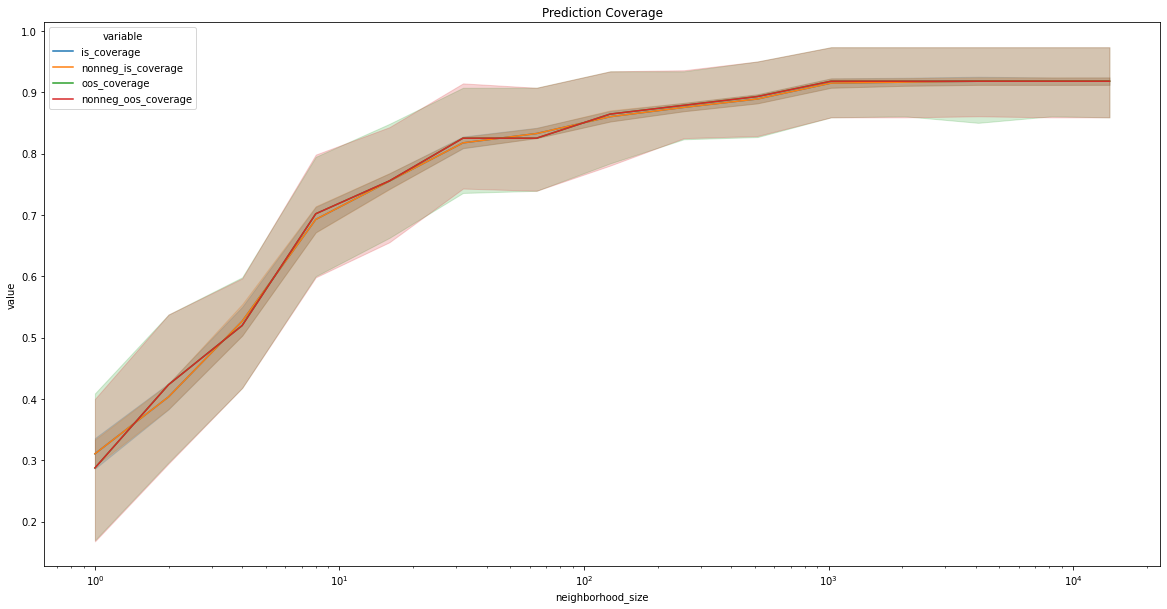

In [21]:
plt.figure(figsize=(20, 10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("coverage")],
).set(xscale="log", title="Prediction Coverage")

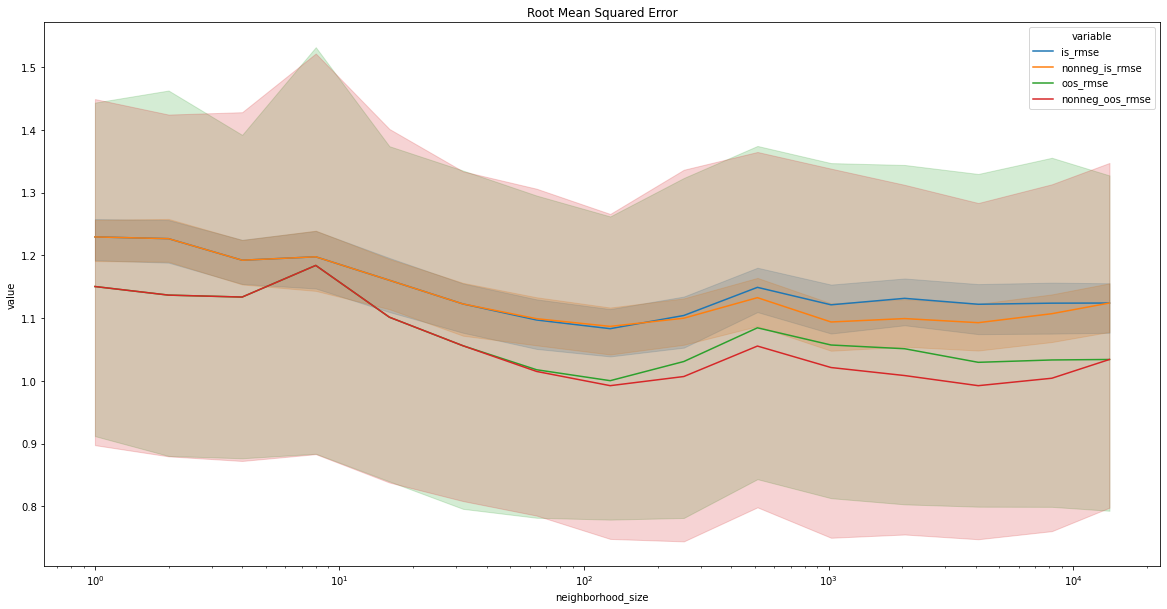

In [22]:
plt.figure(figsize=(20, 10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("rmse")],
).set(xscale="log", title="Root Mean Squared Error")

In [23]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
allerrors.groupby(["nonneg_corrs", "neighborhood_size"]).mean().sort_values(
    by="oos_rmse"
).head(10)

is_coverage   is_rmse  oos_coverage  oos_rmse
nonneg_corrs neighborhood_size                                               
1.0          4096.0                0.917809  1.092787      0.917857  0.992355
             128.0                 0.859977  1.086879      0.864286  0.992363
0.0          128.0                 0.859977  1.083241      0.864286  1.000320
1.0          8192.0                0.917809  1.107116      0.917857  1.004217
             256.0                 0.875198  1.099940      0.878571  1.006955
             2048.0                0.916294  1.099332      0.917857  1.008493
             64.0                  0.832587  1.099131      0.825000  1.015052
0.0          64.0                  0.832587  1.097061      0.825000  1.017742
1.0          1024.0                0.914755  1.093905      0.917857  1.021281
0.0          4096.0                0.917809  1.122155      0.917857  1.029587

In [24]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
allerrors.groupby(["nonneg_corrs", "neighborhood_size"]).mean().xs(
    0, level="nonneg_corrs"
).sort_values(by="oos_rmse").head(10)

,is_coverage,is_rmse,oos_coverage,oos_rmse
neighborhood_size,,,,
128.0,0.859977,1.083241,0.864286,1.000320
64.0,0.832587,1.097061,0.825000,1.017742
4096.0,0.917809,1.122155,0.917857,1.029587
256.0,0.875198,1.104262,0.878571,1.030878
8192.0,0.917809,1.123890,0.917857,1.033344
14091.0,0.917809,1.124099,0.917857,1.034134
2048.0,0.916294,1.131598,0.917857,1.051238
32.0,0.817343,1.122652,0.825000,1.056007
1024.0,0.914755,1.121282,0.917857,1.057200
